In [ ]:
!pip install datasets
!pip install scikit-learn
from datasets import load_dataset
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

# **Task 1: Preprocess the Dataset**

### Load the Dataset

In [ ]:
train_dataset = load_dataset("dair-ai/emotion", split='train')
test_dataset = load_dataset("dair-ai/emotion", split='test')
validation_dataset = load_dataset("dair-ai/emotion", split='validation')

train_df = pd.DataFrame(train_dataset)
test_df = pd.DataFrame(test_dataset)

print(train_df)
print(test_df)

                                                    text  label
0                                i didnt feel humiliated      0
1      i can go from feeling so hopeless to so damned...      0
2       im grabbing a minute to post i feel greedy wrong      3
3      i am ever feeling nostalgic about the fireplac...      2
4                                   i am feeling grouchy      3
...                                                  ...    ...
15995  i just had a very brief time in the beanbag an...      0
15996  i am now turning and i feel pathetic that i am...      0
15997                     i feel strong and good overall      1
15998  i feel like this was such a rude comment and i...      3
15999  i know a lot but i feel so stupid because i ca...      0

[16000 rows x 2 columns]
                                                   text  label
0     im feeling rather rotten so im not very ambiti...      0
1             im updating my blog because i feel shitty      0
2     i never mak

### Show the frequency distribution of the labels

In [ ]:
def show_frequency_distribution(df, title):
  """
    Shows a barplot of the frequency distribution of the labels.
  """
  label_counts = df["label"].value_counts()

  ax = label_counts.plot(
      kind='bar',
      title=title
  )

  ax.set_xlabel("Labels")
  ax.set_ylabel("Count")

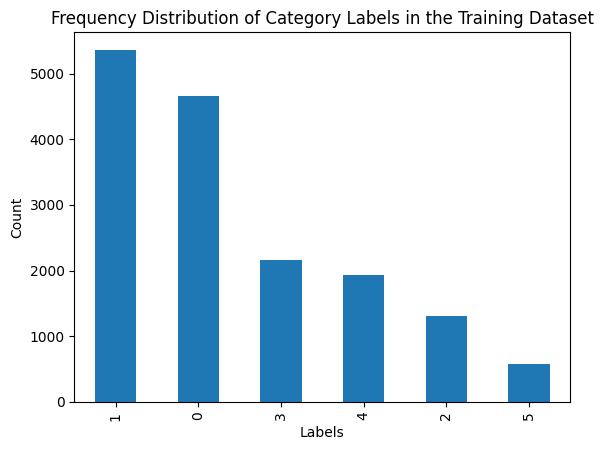

In [ ]:
show_frequency_distribution(train_df, 'Frequency Distribution of Category Labels in the Training Dataset')

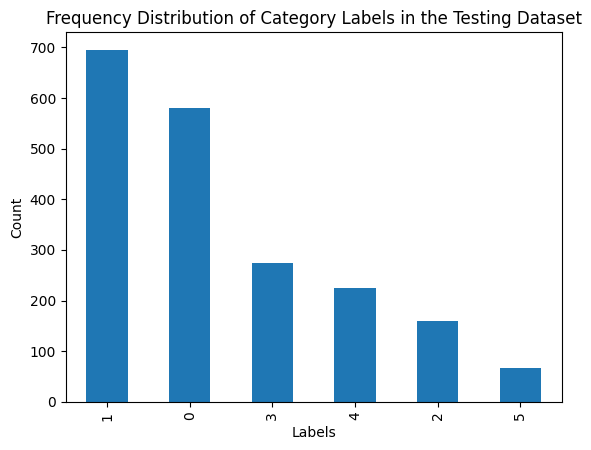

In [ ]:
show_frequency_distribution(test_df, 'Frequency Distribution of Category Labels in the Testing Dataset')

### Implement the bags of words representation

In [ ]:
# Fit the vectorizer on the text data and transform it into a bag of words
vectorizer = CountVectorizer()

X_train = vectorizer.fit_transform(train_df['text'])
y_train = train_df['label']

X_test = vectorizer.transform(test_df['text'])
y_test = test_df['label']

print(vectorizer.vocabulary_)

(16000, 15186)
{'didnt': 3615, 'feel': 4924, 'humiliated': 6429, 'can': 1883, 'go': 5675, 'from': 5385, 'feeling': 4928, 'so': 12304, 'hopeless': 6340, 'to': 13622, 'damned': 3203, 'hopeful': 6338, 'just': 7256, 'being': 1189, 'around': 703, 'someone': 12372, 'who': 14806, 'cares': 1953, 'and': 496, 'is': 7009, 'awake': 931, 'im': 6553, 'grabbing': 5731, 'minute': 8442, 'post': 10140, 'greedy': 5792, 'wrong': 15037, 'am': 434, 'ever': 4563, 'nostalgic': 9046, 'about': 32, 'the': 13425, 'fireplace': 5054, 'will': 14849, 'know': 7418, 'that': 13418, 'it': 7034, 'still': 12719, 'on': 9249, 'property': 10419, 'grouchy': 5830, 'ive': 7051, 'been': 1155, 'little': 7794, 'burdened': 1772, 'lately': 7522, 'wasnt': 14642, 'sure': 13052, 'why': 14824, 'was': 14635, 'taking': 13209, 'or': 9309, 'milligrams': 8401, 'times': 13584, 'recommended': 10815, 'amount': 464, 'fallen': 4815, 'asleep': 769, 'lot': 7896, 'faster': 4861, 'but': 1807, 'also': 415, 'like': 7724, 'funny': 5443, 'as': 747, 'confu

# **Task 2: Implement Naive Bayes and BERT models**

## Naive Bayes Model

In [ ]:
class NaiveBayesClassifier:
    def __init__(self):
        self.class_log_prior_ = None
        self.feature_log_prob_ = None
        self.classes_ = None

    def fit(self, X, y):
        # Count the number of occurrences of each class in the dataset
        count_sample = X.shape[0]
        self.classes_ = np.unique(y)
        n_classes = len(self.classes_)

        # Initialize the log prior and log likelihoods to zero
        self.class_log_prior_ = np.zeros(n_classes)
        self.feature_log_prob_ = np.zeros((n_classes, X.shape[1]))

        # Calculate the log prior and log likelihoods
        for idx, cls in enumerate(self.classes_):
            X_cls = X[y == cls]
            self.class_log_prior_[idx] = np.log(X_cls.shape[0] / count_sample)
            # Laplace smoothing of the feature likelihoods
            self.feature_log_prob_[idx, :] = np.log((X_cls.sum(axis=0) + 1) / (X_cls.sum() + X.shape[1]))

    def predict_log_proba(self, X):
        # Calculate log probability of each class for the input
        return (X @ self.feature_log_prob_.T) + self.class_log_prior_

    def predict(self, X):
        # Use the log probability estimates to make predictions
        log_probs = self.predict_log_proba(X)
        return self.classes_[np.argmax(log_probs, axis=1)]

    def evaluate_acc(self, y_true, y_pred):
        # Calculate the accuracy as the fraction of predictions that match the true labels
        accuracy = np.mean(y_pred == y_true)
        return accuracy

nb_classifier = NaiveBayesClassifier()
nb_classifier.fit(X_train, y_train)
y_pred = nb_classifier.predict(X_test)
accuracy = nb_classifier.evaluate_acc(y_test, y_pred)

print(f"Accuracy of the Naive Bayes classifier: {accuracy * 100:.2f}%")

Accuracy of the Naive Bayes classifier: 76.55%


In [ ]:
from sklearn.metrics import (
    accuracy_score,
    f1_score,
)

y_pred = nb_classifier.predict(X_test)
accuray = accuracy_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test, average="weighted")

print("Accuracy:", accuray)
print("F1 Score:", f1)

Accuracy: 0.7655
F1 Score: 0.8007682644551712


## BERT Model with pre-trained weights

In [ ]:
!pip install -U transformers
from transformers import pipeline
from sklearn.metrics import accuracy_score, f1_score

In [ ]:
# Initialize the mapping between the label names and their integer values.
label_dict = {'sadness': 0, 'joy': 1, 'love': 2, 'anger': 3, 'fear': 4, 'surprise': 5}

# Retrieve the classifier
classifier = pipeline("text-classification",model='bhadresh-savani/bert-base-uncased-emotion', return_all_scores=True)

# Predict labels for the Emotion test dataset
predictions = classifier(list(test_df['text']), batch_size=8)

# Extract the predicted label names
predicted_label_names = [max(prediction, key=lambda x: x['score'])['label'] for prediction in predictions]

# Convert the predicted label names to the corresponding integers
predicted_labels_int = [label_dict[label_name] for label_name in predicted_label_names]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


KeyboardInterrupt: ignored

In [ ]:
# Calculate the accuracy
true_labels = list(test_df['label'])
accuracy = accuracy_score(true_labels, predicted_labels_int)
f1 = f1_score(true_labels,predicted_labels_int)

print(f'Accuracy: {accuracy * 100:.2f}%')
print(f"F1 Score: {f1}")

## Fine-tuned BERT Model

In [ ]:
! pip install -U accelerate
from transformers import Trainer, TrainingArguments, BertForSequenceClassification, BertTokenizer
from sklearn.metrics import accuracy_score, f1_score
import torch
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
#Tokenize the data
tokenizer = BertTokenizer.from_pretrained('bhadresh-savani/bert-base-uncased-emotion')

def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

train_dataset_tokenized = train_dataset.map(tokenize, batched=True, batch_size=None)
train_dataset_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "label"])

test_dataset_tokenized = test_dataset.map(tokenize, batched=True, batch_size=None)
test_dataset_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "label"])

val_dataset_tokenized = validation_dataset.map(tokenize, batched=True, batch_size=None)
val_dataset_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "label"])

In [ ]:
#Function to compute the metrics during training
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [ ]:
def finetune_and_evaluate_model(learning_rate, batch_size, num_epochs, load_best_model_at_end=True):
    """
      This function will finetune and evaluate the accuracy of the BERT model
      given the different hyperparameters.
    """
    model = BertForSequenceClassification.from_pretrained('bhadresh-savani/bert-base-uncased-emotion', num_labels=6)
    model.to(device)

    training_args = TrainingArguments(
        output_dir='results',
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=num_epochs,
        evaluation_strategy='epoch',
        load_best_model_at_end=load_best_model_at_end,
        metric_for_best_model="f1", # F1 seems to be a better metric since dataset is imbalanced
        weight_decay=0.01, # adding regularization
        save_strategy="epoch",
        disable_tqdm=False
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset_tokenized,
        eval_dataset=val_dataset_tokenized,
        compute_metrics=compute_metrics
    )

    trainer.train()
    validation_results = trainer.evaluate()
    test_results = trainer.evaluate(test_dataset_tokenized)
    return validation_results['eval_accuracy'], test_results['eval_accuracy']

## Extra Experiments: Varying Hyperparameters

In [ ]:
# Function to plot a graph of the validation and test accuracies
def plot_results(x, y1, y2, x_label, title):
    plt.figure(figsize=(10, 6))
    plt.plot(x, y1, marker='o', label='Validation Accuracy')
    plt.plot(x, y2, marker='x', label='Test Accuracy')
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel("Accuracy")
    plt.xscale("log")
    plt.legend()
    plt.show()

In [ ]:
# Fixed hyperparameters
fixed_lr = 1e-5
fixed_batch_size = 64
fixed_num_epochs = 4

In [ ]:
# Experiment 1: Varying learning rates
learning_rates = [5e-7, 1e-6, 5e-6, 1e-5, 5e-5, 1e-4]
lr_val_results, lr_test_results = [], []

for lr in learning_rates:
    val_accuracy, test_accuracy = finetune_and_evaluate_model(lr, fixed_batch_size, fixed_num_epochs)
    print("lr:", lr, "Accuracies:", val_accuracy, test_accuracy)
    lr_val_results.append(val_accuracy)
    lr_test_results.append(test_accuracy)

plot_results(learning_rates, lr_val_results, lr_test_results, "Learning Rate", "Model Accuracy vs Learning Rate")

In [ ]:
# Experiment 2: Varying number of epochs
num_epochs_list = [1, 2, 4, 8]
epoch_val_results, epoch_test_results = [], []

for epochs in num_epochs_list:
    val_accuracy, test_aecuracy = finetune_and_evaluate_model(fixed_lr, fixed_batch_size, epochs, False)
    print("epochs:", epochs, "Accuracies:", val_accuracy, test_accuracy)
    epoch_val_results.append(val_accuracy)
    epoch_test_results.append(test_accuracy)

plot_results(num_epochs_list, epoch_val_results, epoch_test_results, "Number of Epochs", "Model Accuracy vs Number of Epochs")

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.097300,0.203681,0.937500,0.937541
2,0.072300,0.294086,0.930500,0.931124
3,0.047400,0.295240,0.937000,0.936690
4,0.025000,0.300057,0.937500,0.937348


batch_size: 16 Accuracies: 0.9375 0.9275


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.072100,0.190109,0.937000,0.937380
2,0.053000,0.214911,0.937000,0.937442
3,0.039200,0.232592,0.937000,0.937145
4,0.027400,0.234732,0.941500,0.941374


batch_size: 32 Accuracies: 0.9415 0.923


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.170281,0.939500,0.939613
2,0.056000,0.188973,0.937500,0.938103
3,0.056000,0.197294,0.939000,0.938972
4,0.035300,0.201715,0.941000,0.940908


batch_size: 64 Accuracies: 0.941 0.9245


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.167575,0.938500,0.938454
2,No log,0.176080,0.940500,0.940585
3,No log,0.177590,0.938500,0.938619
4,0.045700,0.183191,0.939000,0.938910


batch_size: 128 Accuracies: 0.9405 0.925


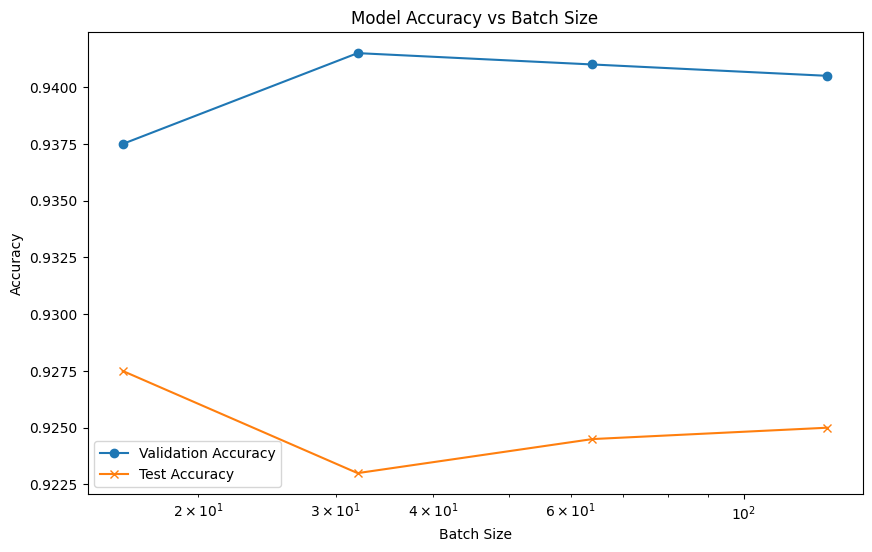


Batch Size Results:
   Batch Size  Validation Accuracy  Test Accuracy
0          16               0.9375         0.9275
1          32               0.9415         0.9230
2          64               0.9410         0.9245
3         128               0.9405         0.9250


In [ ]:
# Experiment 3: Varying batch sizes
batch_sizes = [16, 32, 64, 128]
batch_size_val_results, batch_size_test_results = [], []

for batch_size in batch_sizes:
    val_accuracy, test_accuracy = finetune_and_evaluate_model(fixed_lr, batch_size, fixed_num_epochs)
    print("batch_size:", batch_size, "Accuracies:", val_accuracy, test_accuracy)
    batch_size_val_results.append(val_accuracy)
    batch_size_test_results.append(test_accuracy)

plot_results(batch_sizes, batch_size_val_results, batch_size_test_results, "Batch Size", "Model Accuracy vs Batch Size")

In [ ]:
# Experiment 2: Varying number of epochs
num_epochs_list = [1, 2, 4, 8]
epoch_val_results, epoch_test_results = [], []

for epochs in num_epochs_list:
    val_accuracy, test_accuracy = finetune_and_evaluate_model(fixed_lr, fixed_batch_size, epochs, False)
    print("epochs:", epochs, "Accuracies:", val_accuracy, test_accuracy)
    epoch_val_results.append(val_accuracy)
    epoch_test_results.append(test_accuracy)

plot_results(num_epochs_list, epoch_val_results, epoch_test_results, "Number of Epochs", "Model Accuracy vs Number of Epochs")

epoch_table = create_table(num_epochs_list, epoch_val_results, epoch_test_results, "Number of Epochs", "Validation Accuracy", "Test Accuracy")
print("\nNumber of Epochs Results:")
print(epoch_table)

## Experiment for investigating attention matrix

In [ ]:
classifier = pipeline("text-classification", model='bhadresh-savani/bert-base-uncased-emotion', return_all_scores=True)
all_predictions = [classifier(text) for text in test_dataset_df['text'].tolist()]

In [ ]:
pred_labels = []
label_dict = {'sadness': 0, 'joy': 1, 'love': 2, 'anger': 3, 'fear': 4, 'surprise': 5}

for pred_score_list in all_predictions:
   max_score_dict = max(pred_score_list[0], key=lambda x: x['score'])
   #print(pred_score_list[0])
   pred_labels.append(label_dict[max_score_dict['label']])

true_labels = test_dataset_df['label'].tolist()

In [ ]:
test_dataset_df['pred_label'] = pred_labels

correct_predictions = test_dataset_df[test_dataset_df['pred_label'] == test_dataset_df['label']]['text']
wrong_predictions = test_dataset_df[test_dataset_df['pred_label'] != test_dataset_df['label']]['text']

NameError: ignored

In [ ]:
!pip install bertviz

In [ ]:
from transformers import AutoTokenizer, AutoModel
from bertviz import head_view
from bertviz.neuron_view import show

model_ckpt = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

model = AutoModel.from_pretrained(model_ckpt, output_attentions=True)

#the indiex were changed to investigate different sentences
sentence_a = wrong_predictions[72]
sentence_b = wrong_predictions[94]


viz_inputs = tokenizer(sentence_a, sentence_b, return_tensors='pt')
print(viz_inputs)

attention = model(**viz_inputs).attentions
sentence_b_start = (viz_inputs.token_type_ids == 0).sum(dim=1)
tokens = tokenizer.convert_ids_to_tokens(viz_inputs.input_ids[0])

print(tokens)
head_view(attention, tokens, sentence_b_start, heads=[8])